<a href="https://colab.research.google.com/github/devinbelden/capstone-project/blob/master/Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Obtain/Scrub

If you want to follow along in your own drive, the first step you'll need to take is to download the LISA dataset. Click [here](https://drive.google.com/file/d/1Cs3wEm_DQoLz-oF6gJcN7e1yfpbdNiWk/view?usp=sharing) to access a modified version of the zip file to place in your own Google Drive. This modified zip file contains an additional set of screenshots from Google Images and Google Street View, located in the folder `prediction_images`. 

Once the zip file is in the Drive directory you want it in, the following blocks of code will unzip the data within Google Colab.

In [2]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
%cd ~
%cd ..

Mounted at /gdrive
/root
/


In [3]:
import os,glob

print(os.path.abspath(os.curdir))

# change the next line of code to reflect the location of the zip file in your own Drive
source_folder = r'/gdrive/My Drive/Datasets/' 
file = glob.glob(source_folder+'*.zip',recursive=True)[0]
file

/


'/gdrive/My Drive/Datasets/LISA_dataset.zip'

In [0]:
zip_path = file

!cp "{zip_path}" .

!unzip -q LISA_dataset.zip 
!rm LISA_dataset.zip 

After the above cells run, the below cell will check to see if we've gotten all the directories we need.

In [5]:
print(os.path.abspath(os.curdir))
os.listdir()

/


['var',
 'lib',
 'sys',
 'sbin',
 'usr',
 'media',
 'mnt',
 'srv',
 'boot',
 'etc',
 'opt',
 'root',
 'run',
 'proc',
 'tmp',
 'home',
 'bin',
 'lib64',
 'dev',
 'vid3',
 'aiua120306-0',
 'vid10',
 'vid6',
 'vid11',
 'vid2',
 'vid1',
 'vid4',
 'aiua120306-1',
 'vid5',
 'vid0',
 'aiua120214-0',
 'aiua120214-1',
 'vid7',
 'allAnnotations.csv',
 'prediction_images',
 'vid8',
 'gdrive',
 'vid9',
 'aiua120214-2',
 '.dockerenv',
 'datalab',
 'tools',
 'swift',
 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl',
 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl',
 'tensorflow-1.15.0',
 'content',
 'lib32']

##Explore 

Now we're ready to import a few packages and explore our data. Fortuitously, the annotations are stored in a convenient CSV for us, complete with bounding box coordinates. While bounding boxes are outside the scope of this project in its current form, they are planned to be implemented in a future update.

In [6]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [7]:
import tensorflow as tf

print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

The `allAnnotations` CSV will be invaluable in accessing the filenames of the individual pictures that we will collect to form our train-test split. Let's import that now.

Word of note: Only the images from the original LISA dataset have annotations stored within the `allAnnotations.csv` file. The images within the `prediction_images` folder do not have annotations. 

In [8]:
import pandas as pd

annotations = pd.read_csv('allAnnotations.csv', sep=';')
annotations.head()

Filename  ... Origin track frame number
0  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         2
1  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         2
2  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         7
3  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         7
4  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                        12

[5 rows x 11 columns]

Now that we've imported our dataframe, let's take a look at the class prevalence, as well as investigate any class imbalance that may be present.

In [9]:
labels = annotations['Annotation tag'].nunique()
pictures = annotations['Filename'].nunique()

print(f"There are {labels} unique labels across {pictures} unique pictures.")

There are 47 unique labels across 6618 unique pictures.


Text(0.5, 1.0, 'Prevalence of Each Annotation Tag')

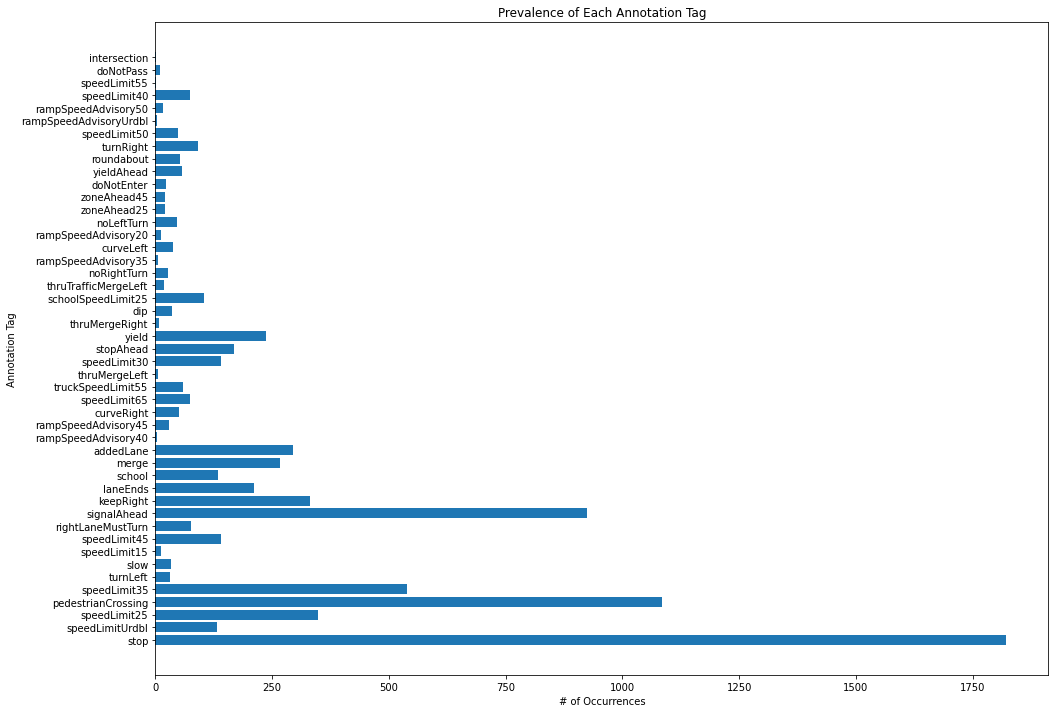

In [10]:
import matplotlib.pyplot as plt

y = annotations['Annotation tag'].unique()
x = [len(annotations[annotations['Annotation tag'] == tag]) for tag in y]

plt.figure(figsize=(16,12))
plt.barh(y, x)
plt.ylabel('Annotation Tag')
plt.xlabel('# of Occurrences')
plt.title('Prevalence of Each Annotation Tag')

At this point, we should investigate the number of images with more than one annotation. For simplicity's sake, we'll eliminate all occurrences of this happening by dropping any row in `annotations` with a duplicate `Filename`. Afterwards, we'll replot the above graph according to our new statistics.

Text(0.5, 1.0, 'Prevalence of Each Annotation Tag')

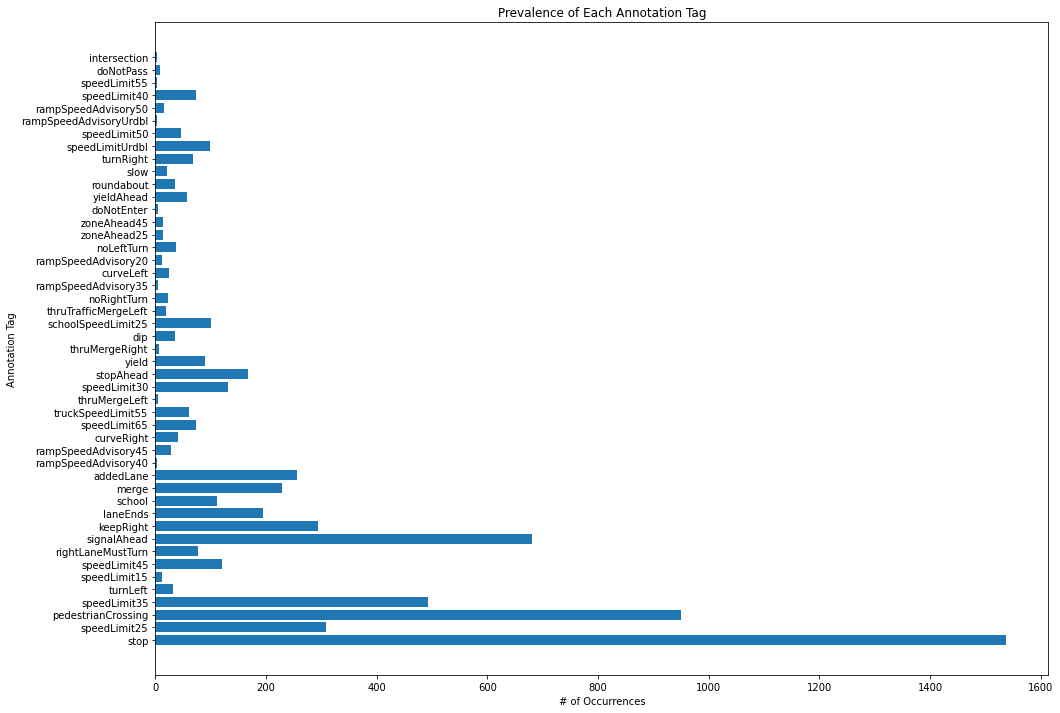

In [11]:
annotations.drop_duplicates(subset='Filename',
                            keep='first',
                            inplace=True)

y = annotations['Annotation tag'].unique()
x = [len(annotations[annotations['Annotation tag'] == tag]) for tag in y]

plt.figure(figsize=(16,12))
plt.barh(y, x)
plt.ylabel('Annotation Tag')
plt.xlabel('# of Occurrences')
plt.title('Prevalence of Each Annotation Tag')

Due to the number of unique labels, as well as the large imbalance in class occurrence, we'll only take a look at the top 5 most common classes in order to train our model. Naturally, we'll only test this model on those 5 classes as well.

In [12]:
print(annotations['Annotation tag'].value_counts()[:5])

sum(annotations['Annotation tag'].value_counts()[:5])

stop                  1537
pedestrianCrossing     950
signalAhead            681
speedLimit35           492
speedLimit25           308
Name: Annotation tag, dtype: int64


3968

In [73]:
tags = ['pedestrianCrossing','signalAhead','speedLimit25','speedLimit35','stop']

clippedAnnotations = annotations[(annotations['Annotation tag'] == tags[0]) |
                                 (annotations['Annotation tag'] == tags[1]) |
                                 (annotations['Annotation tag'] == tags[2]) |
                                 (annotations['Annotation tag'] == tags[3]) |
                                 (annotations['Annotation tag'] == tags[4])]

clippedAnnotations = clippedAnnotations.reset_index(drop=True)
total = len(clippedAnnotations)
unique = clippedAnnotations['Filename'].nunique()

clippedAnnotations.head()

Filename  ... Origin track frame number
0  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         2
1  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         7
2  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                        12
3  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         2
4  aiua120214-0/frameAnnotations-DataLog02142012_...  ...                         9

[5 rows x 11 columns]

In [14]:
print(f"There are {unique} unique filenames and {total} total images.")

There are 3968 unique filenames and 3968 total images.


Perfect. All duplicity has been eliminated, and we can continue with data scrubbing. At this point, we should consider that our pictures not only might have different resolutions, but different aspect ratios as well. To test this claim, we'll open each individual image, extract its dimensions, and append those to lists for height and width. 

On our way, we'll calculate the mean and the standard deviation of all the aspect ratios.

In [15]:
import numpy as np
import os
from PIL import Image

widths = []
heights = []

for filename in list(clippedAnnotations['Filename']):
    image = Image.open(filename) 
    orig_w, orig_h = image.size
    widths.append(orig_w)
    heights.append(orig_h)

aspect_ratios = np.array(np.array(widths)/np.array(heights))

# having lists of values is a convenient way to add them to our dataframe
clippedAnnotations['imageWidth'] = widths
clippedAnnotations['imageHeight'] = heights
clippedAnnotations['aspectRatio'] = aspect_ratios

clippedAnnotations.head()

Filename  ... aspectRatio
0  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686
1  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686
2  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686
3  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686
4  aiua120214-0/frameAnnotations-DataLog02142012_...  ...    1.961686

[5 rows x 14 columns]

In [16]:
clippedAnnotations['aspectRatio'].value_counts()

1.961686    2213
1.466667    1232
1.333333     523
Name: aspectRatio, dtype: int64

At this point, we have a decision to make. The model that is about to be created can only take in one unique image size, and therefore one unique aspect ratio, but to which ratio should all of our images be converted? Should it be the mode, i.e. 1.96? That would cause no distortion to the majority of our images, but quite a bit of distortion to a not insignificant fraction of our data. Should it then be the unweighted average, 1.59, or should it be the weighted average, 1.73? 

Resizing our data to the weighted average seems like a good middle ground to explore. Note that there are [ways](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) of creating models that accept multiple input sizes, but that is outside the scope of this project in its current state. Thus, we will forge ahead with our target aspect ratio of 1.73. 

A good resolution that has this approximate aspect ratio is 400x230.

In [17]:
# resize image while preserving average aspect ratio
# send modified images to new directory
# running this cell multiple times will cause duplicates between train-test split
# so we just run this cell once

import random

go_ahead = input("Split may have already been created. Creating another one \
without changing directories will cause duplicates between splits. Run this cell? y/n ")

if go_ahead == 'y':

  random.seed(42) # create seed for reproducibility

  os.mkdir('resized_images_400x230') # all resized images go here
  os.mkdir('resized_images_400x230/test/')
  os.mkdir('resized_images_400x230/train/')

  test_count = 0
  train_count = 0

  for tag in tags: 
    
    for index, row in clippedAnnotations[clippedAnnotations['Annotation tag'] == tag].iterrows():
    
      filename = row['Filename']
      image = Image.open(row['Filename'])
      target_w, target_h = 400, 230 # preserves 1.74 mean aspect ratio
      image = image.resize((target_w, target_h), Image.LANCZOS)
            
        
      # RNG way of creating 95-5 train-test split
      num = random.randint(1,100)
      if num > 95:
        test_count += 1
        directory = 'resized_images_400x230/test/' + tag + '/'
        if not os.path.isdir(directory):
          os.mkdir(directory)
        resized_dir = directory
        
      else:
        train_count += 1
        directory = 'resized_images_400x230/train/' + tag + '/'
        if not os.path.isdir(directory):
          os.mkdir(directory)
        resized_dir = directory
        
      image.save((resized_dir+str(index)+'.png'), format='png')

else:
  pass

Split may have already been created. Creating another one without changing directories will cause duplicates between splits. Run this cell? y/n y


In [18]:
print(train_count, test_count)

3757 211


## Model

At this point, we're ready to create a classification model for training. For purposes of the `ImageDataGenerator` instance for the training data generator, we do not use any zooming due to many of the traffic signs occurring at the very edge of the picture to begin with. Zooming in would cut off those traffic signs and throw off the data. 

Additionally, we do not use horizontal or vertical flipping, as real-world orientation plays a big part in determining what the sign actually means. For example, a "No Right Turn" sign flipped horizontally becomes a "No Left Turn" sign, and would therefore be misclassified by the model. 

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/resized_images_400x230/train/'
val_dir = '/resized_images_400x230/test/'

train_batch_size = 30
val_batch_size = 10

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=0.2,
                                   shear_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(230, 400),
        batch_size=train_batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(230, 400),
        batch_size=val_batch_size,
        class_mode='categorical')

Using TensorFlow backend.


Found 3757 images belonging to 5 classes.
Found 211 images belonging to 5 classes.


In [20]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(230,400,3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 228, 398, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 114, 199, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 114, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 195, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 97, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 97, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 95, 128)       7

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

def create_csvlogger(filename):
    return CSVLogger(filename, separator=',', append=False)

def create_checkpoint(monitor='val_acc',model_subfolder='/gdrive/My Drive/Datasets/models/'):
    filepath=model_subfolder+"weights-improvement-{epoch:02d}-{"+monitor+":.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1, save_best_only=True, mode='max')
    return checkpoint

def create_early_stopping(monitor = 'val_acc',min_delta = 0, patience = 3,
                          verbose = 1, restore_best_weights = True):

    args = locals()
    earlystop = EarlyStopping(**args)
    return earlystop

In [22]:
model_subfolder='/gdrive/My Drive/Datasets/models/'
callbacks_list = [create_checkpoint('val_acc'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log.csv')]
callbacks_list

In [0]:
train_steps = train_count//train_batch_size
val_steps = test_count//val_batch_size

print(train_steps, val_steps)

125 20


In [0]:
history = model.fit(train_generator, 
                    steps_per_epoch=(train_count//train_batch_size), 
                    epochs=25, 
                    validation_data=validation_generator, 
                    validation_steps=test_count//val_batch_size,
                    callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 20 steps
Epoch 1/25
124/125 [============================>.] - ETA: 0s - loss: 1.4482 - acc: 0.3922
Epoch 00001: val_acc improved from -inf to 0.44000, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-01-0.44.hdf5
125/125 [==============================] - 80s 642ms/step - loss: 1.4502 - acc: 0.3904 - val_loss: 1.5462 - val_acc: 0.4400
Epoch 2/25
124/125 [============================>.] - ETA: 0s - loss: 1.3989 - acc: 0.4176
Epoch 00002: val_acc improved from 0.44000 to 0.44500, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-02-0.44.hdf5
125/125 [==============================] - 76s 609ms/step - loss: 1.3999 - acc: 0.4166 - val_loss: 1.4947 - val_acc: 0.4450
Epoch 3/25
124/125 [============================>.] - ETA: 0s - loss: 1.3616 - acc: 0.4373
Epoch 00003: val_acc did not improve from 0.44500
125/125 [==============================] - 76s 607ms/step - loss:

This model apparently attained 85.5% validation accuracy. Not bad, especially for a preliminary model! We can definitely do better, but let's figure out *how* to do better first, by visualizing the prediction results.

In [0]:
# skipping model compilation/training 
model = models.load_model('/gdrive/My Drive/Datasets/models/weights-improvement-14-0.86.hdf5')

## Visualizing Results

At this point, we should take a look at some of the images and how our model classifies them. Below is a function that outputs the input image, which will be selected from the `test` folder, and a bar graph showing the confidence levels for each label predicted by the model.

In [0]:
def make_prediction_graph(image_path, model):
  import matplotlib.pyplot as plt
  from matplotlib import image
  
  img = image.imread(image_path)
  img_array = np.expand_dims(img, axis=0)

  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,7))
  labels = ['Pedestrian Crossing','Signal Ahead','25 Speed Limit','35 Speed Limit','Stop Sign']
  predictions = model.predict(img_array).tolist()[0]

  ax1.imshow(img)
  ax2.bar(x=labels, height=predictions)

  return 

Below is a selection of images from each label. Sometimes the model gets it right...

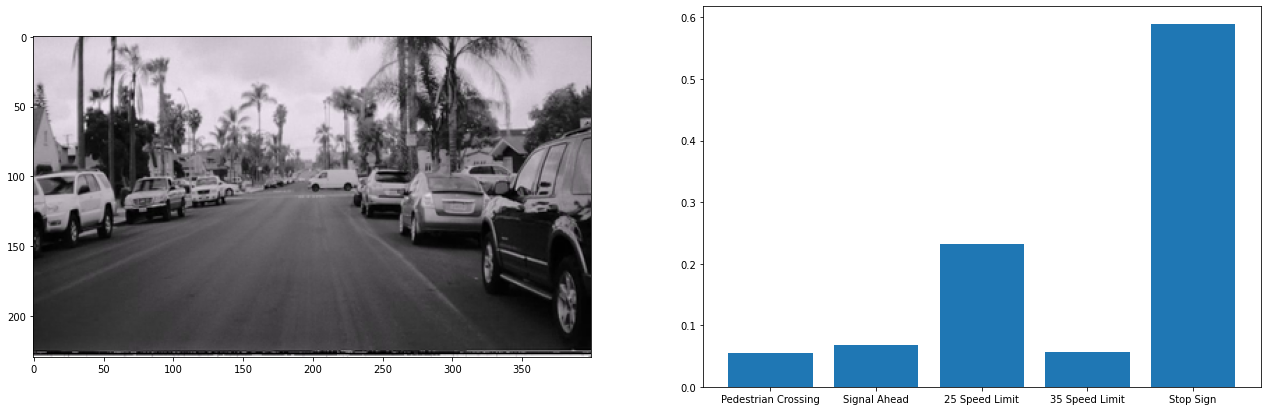

In [25]:
make_prediction_graph('/resized_images_400x230/test/stop/1008.png',
                      model)

And sometimes it gets them very wrong.

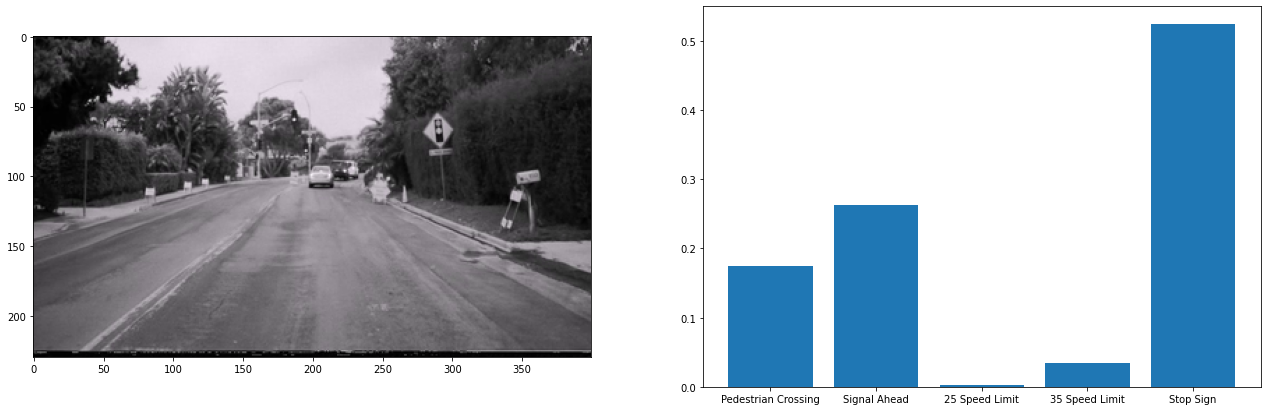

In [31]:
make_prediction_graph('/resized_images_400x230/test/signalAhead/1944.png',
                      model)

What causes this? A human can clearly see that this is a signal ahead sign, but what is a computer seeing that makes it think it's a stop sign instead?

To help answer this, we'll make use of [Lime Image Viewer](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb). This is a package that uses colored "superpixels" to help us visualize the classification criteria that the model learns. In other words, it will help us understand the physical parts of the images that contribute positively and negatively towards one label over the others.

In [32]:
pip install lime

     |████████████████████████████████| 276kB 3.3MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=2557a14f6e7f5d3d26d920b09d2041dce69bd856c2d985e8ccd6cb36c7f3e140
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=57085075a168c2ea618f908defa25445799515f4b910dd7cb538a3b5bcf51310
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
import lime
from lime import lime_image

The below function, much like the `make_prediction_graph` function from earlier, takes in an image path and a model as inputs, and plots the original image on the left, with the Lime Explained image on the right. 

In [0]:
def lime_explain(image_path, model):

  from PIL import Image
  import numpy as np
  from skimage.segmentation import mark_boundaries
  import matplotlib.pyplot as plt

  image = Image.open(image_path)
  image_array = np.asarray(image)
  explainer = lime_image.LimeImageExplainer()

  explanation = explainer.explain_instance(image_array, 
                                           model.predict, 
                                           top_labels=5,
                                           hide_color=0,
                                           num_samples=1000)
  
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                              positive_only=False, 
                                              num_features=5, 
                                              hide_rest=False)
  
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,7))
  ax1.imshow(image)
  ax2.imshow(mark_boundaries(temp, mask))

  return

We'll test drive this function by plotting the correctly-predicted stop sign picture, just to ensure that the model is predicting Stop Sign based on the physical attributes of a stop sign.

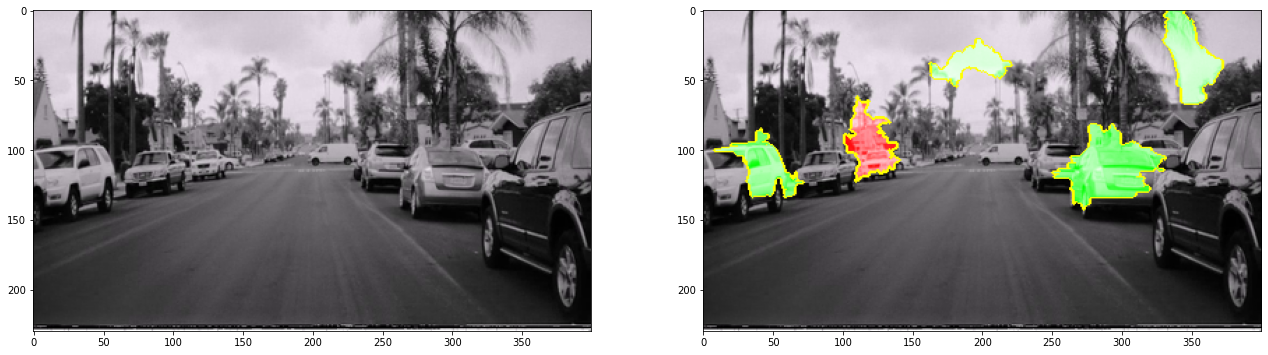

In [35]:
lime_explain('/resized_images_400x230/test/stop/1008.png',
             model)

Uh oh. It seems like the existence of an actual stop sign contributes absolutely nothing to the prediction of one! This is definitely a problem, as we don't want our computers to base their prediction of a stop sign on anything other than a white STOP emblazoned on a red octagon. So, while the model got this prediction correct according to the *label*, Lime has shown us that the model got it wrong according to the *pixels*.

We knew our model could use some tuning, and now we have a visual (and hopefully more visceral) grasp on that fact. We could stop here and dive right back into the model, but let's check the other image in the interest of integrity.

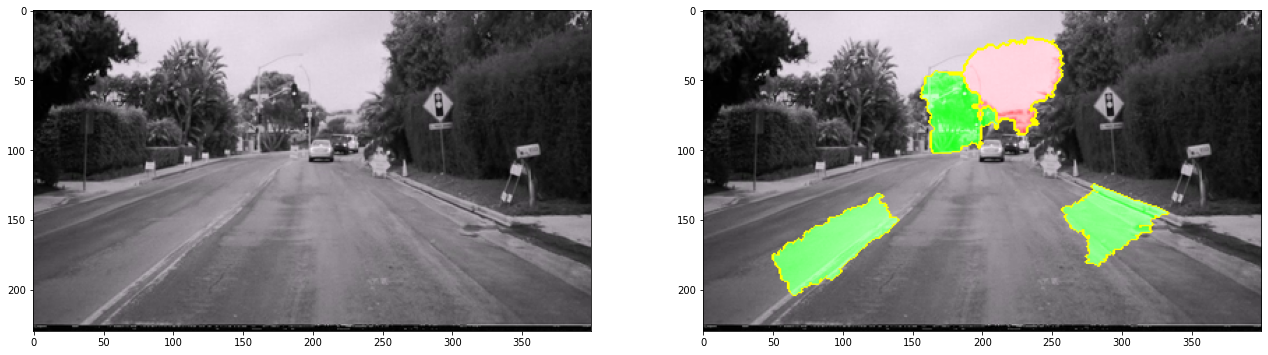

In [36]:
lime_explain('/resized_images_400x230/test/signalAhead/1944.png',
             model)

Likewise, the model is not taking into account the physical attributes of the sign in order to make its prediction. This time, the prediction was entirely wrong, but that was to be expected, given the results of the last picture.

In the interest of higher prediction accuracy, let's create a different neural network in the hopes of increasing our model's prediction ability and reasoning. For this, we'll start with increasing the depth of the model, which will increase training time. To counteract this, we'll follow up with increasing our kernel size in the first layer to train more quickly. We'll add additional layers in the Dense block as well. Finally, in order to obtain a slightly higher level of generalizability, we'll make our dropout layers more aggressive.

In [0]:
model_2 = models.Sequential([
          layers.Conv2D(32, (7, 7), activation='relu',
                        input_shape=(230,400,3)),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(64, (5, 5), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(128, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(128, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(256, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Conv2D(256, (3, 3), activation='relu'),
          layers.MaxPooling2D((2, 2)),
          layers.Dropout(0.5),

          layers.Flatten(),
          layers.Dense(64, activation='relu'),
          layers.Dense(128, activation='relu'),
          layers.Dense(256, activation='relu'),
          layers.Dense(512, activation='relu'),
          layers.Dense(512, activation='relu'),
          layers.Dense(1024, activation='relu'),
          layers.Dense(5, activation='softmax')
])


We'll change up the CSV log file name for distinguishing between models.

In [0]:
callbacks_list = [create_checkpoint('val_acc'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log_2.csv')]
callbacks_list

In [0]:
model_2.compile(loss='categorical_crossentropy',
                optimizer="sgd",
                metrics=['acc'])

In [0]:
history_2 = model_2.fit(train_generator, 
                        steps_per_epoch=(train_count//train_batch_size), 
                        epochs=25, 
                        validation_data=validation_generator, 
                        validation_steps=test_count//val_batch_size,
                        callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 20 steps
Epoch 1/25
124/125 [============================>.] - ETA: 0s - loss: 1.4815 - acc: 0.3812
Epoch 00001: val_acc improved from -inf to 0.29000, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-01-0.29.hdf5
125/125 [==============================] - 74s 592ms/step - loss: 1.4805 - acc: 0.3819 - val_loss: 1.5820 - val_acc: 0.2900
Epoch 2/25
124/125 [============================>.] - ETA: 0s - loss: 1.4597 - acc: 0.3868
Epoch 00002: val_acc did not improve from 0.29000
125/125 [==============================] - 72s 576ms/step - loss: 1.4607 - acc: 0.3861 - val_loss: 1.5848 - val_acc: 0.2400
Epoch 3/25
124/125 [============================>.] - ETA: 0s - loss: 1.4534 - acc: 0.3879
Epoch 00003: val_acc did not improve from 0.29000
125/125 [==============================] - 72s 577ms/step - loss: 1.4542 - acc: 0.3869 - val_loss: 1.5897 - val_acc: 0.2400
Epoch 4/25
124/125 [========

In [0]:
# loading model_2 from callback file
model_2 = models.load_model('/gdrive/My Drive/Datasets/models/weights-improvement-01-0.29.hdf5')

A more complex model yielded a much lower validation accuracy of 29%, which is barely better than random guessing. Let's check the predictions and Lime explanations for the same images as before.

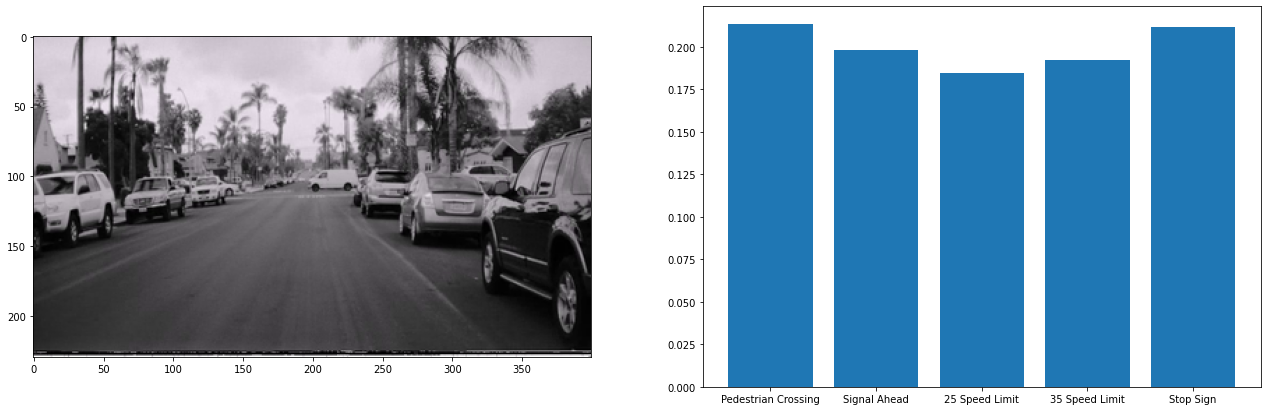

In [40]:
make_prediction_graph('/resized_images_400x230/test/stop/1008.png',
                      model_2)

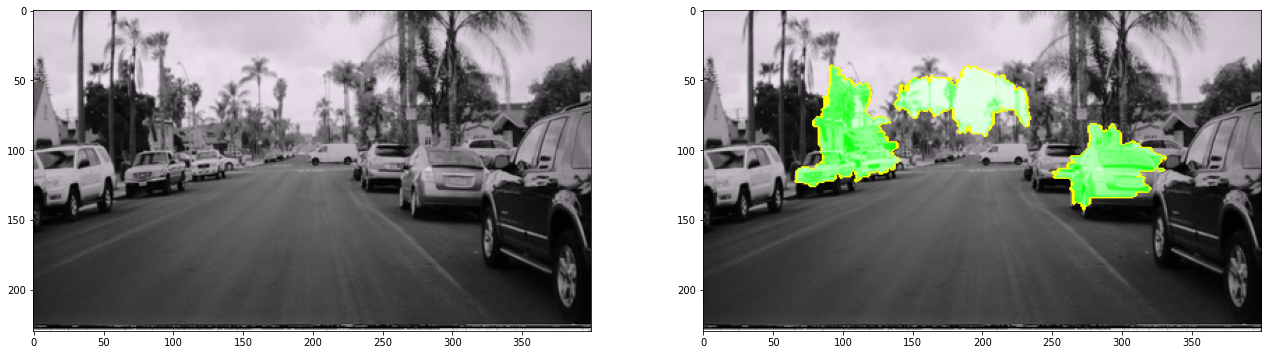

In [38]:
lime_explain('/resized_images_400x230/test/stop/1008.png',
             model_2)

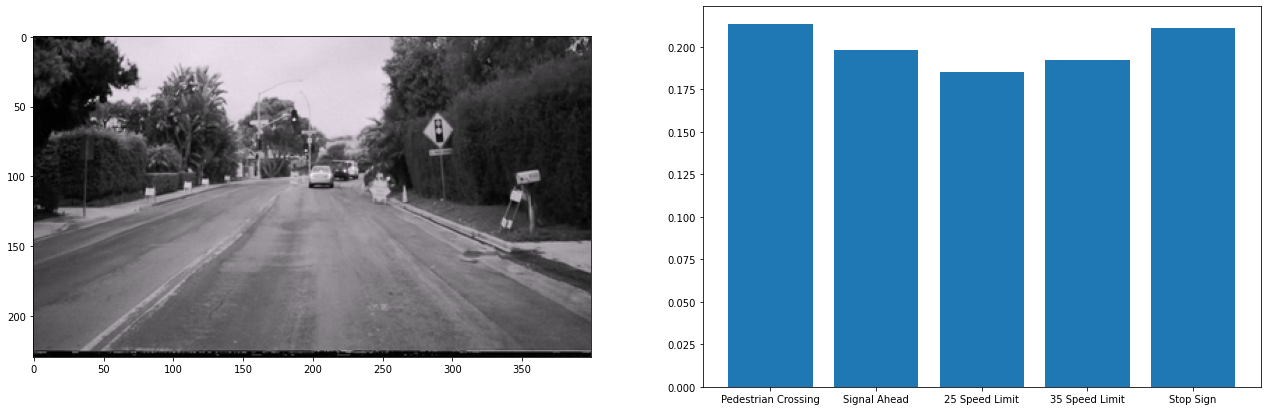

In [41]:
make_prediction_graph('/resized_images_400x230/test/signalAhead/1944.png',
                      model_2)

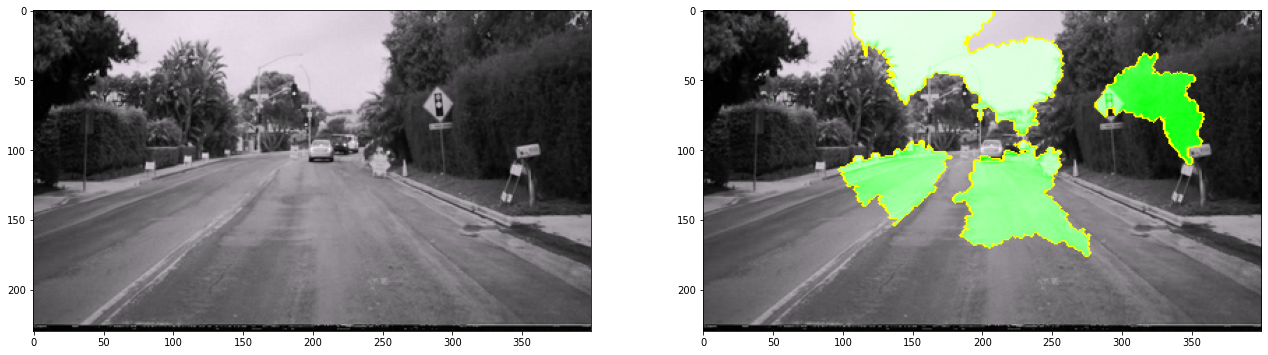

In [39]:
lime_explain('/resized_images_400x230/test/signalAhead/1944.png',
             model_2)

It is interesting how, in the first case, the sign itself is not present in the "positive" superpixels that contribute to the model's (usually incorrect) prediction. It's as though our model would misclassify a dog as a cat based solely on the presence of a litterbox. 

In the second case, however, the model is *looking* at the sign, but still getting the classification wrong. In both cases, however, despite the higher depth of the model, it is much less confident in its responses.

One of the ways of rectifying this problem is to vastly increase the amount and variety of training data, in the hopes of the model nailing down precisely what a traffic sign looks like on its own. It's no secret that all or nearly all of the data in the LISA dataset comes from urban California, and introducing some other landscapes into the mix would, at the very least, help our model distinguish what a traffic sign *isn't*, which is palm trees and blue sky. 

## Transfer Learning

Increasing our data is outside the scope of this project (for now), but what about transfer learning? There's no need to climb that mountain if someone else already built an escalator, right?

In [0]:
from tensorflow.keras.applications import VGG19

cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(230, 400, 3))

# Define Model Architecture
model_3 = models.Sequential([
                 cnn_base,
                 layers.Flatten(),
                 layers.Dense(64, activation='relu'),
                 layers.Dense(128, activation='relu'),
                 layers.Dense(256, activation='relu'),
                 layers.Dense(512, activation='relu'),
                 layers.Dense(5, activation='softmax')
])

cnn_base.trainable = False

for layer in model_3.layers:
    print(layer.name, layer.trainable)
    
print(len(model_3.trainable_weights))

model_3.summary()

vgg19 False
flatten_9 True
dense_51 True
dense_52 True
dense_53 True
dense_54 True
dense_55 True
10
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 12, 512)        20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 43008)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                2752576   
_________________________________________________________________
dense_52 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_53 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_54 (Dense)             (None, 512)               131584    
____________________

In [0]:
model_3.compile(loss='categorical_crossentropy',
                optimizer="sgd",
                metrics=['acc'])

In [0]:
callbacks_list = [create_checkpoint('val_acc'),
                  create_early_stopping(),
                  create_csvlogger(model_subfolder+'callback_log_3.csv')]
callbacks_list

In [0]:
history_3 = model_3.fit(train_generator, 
                        steps_per_epoch=(train_count//train_batch_size), 
                        epochs=25, 
                        validation_data=validation_generator, 
                        validation_steps=test_count//val_batch_size,
                        callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 125 steps, validate for 20 steps
Epoch 1/25
124/125 [============================>.] - ETA: 0s - loss: 1.4659 - acc: 0.3863
Epoch 00001: val_acc improved from -inf to 0.40000, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-01-0.40.hdf5
125/125 [==============================] - 76s 610ms/step - loss: 1.4651 - acc: 0.3880 - val_loss: 1.3592 - val_acc: 0.4000
Epoch 2/25
124/125 [============================>.] - ETA: 0s - loss: 1.3771 - acc: 0.4176
Epoch 00002: val_acc improved from 0.40000 to 0.40500, saving model to /gdrive/My Drive/Datasets/models/weights-improvement-02-0.41.hdf5
125/125 [==============================] - 76s 608ms/step - loss: 1.3783 - acc: 0.4166 - val_loss: 1.3407 - val_acc: 0.4050
Epoch 3/25
124/125 [============================>.] - ETA: 0s - loss: 1.3278 - acc: 0.4578
Epoch 00003: val_acc did not improve from 0.40500
125/125 [==============================] - 75s 603ms/step - loss:

In [0]:
model_3 = models.load_model('/gdrive/My Drive/Datasets/models/weights-improvement-08-0.64.hdf5')

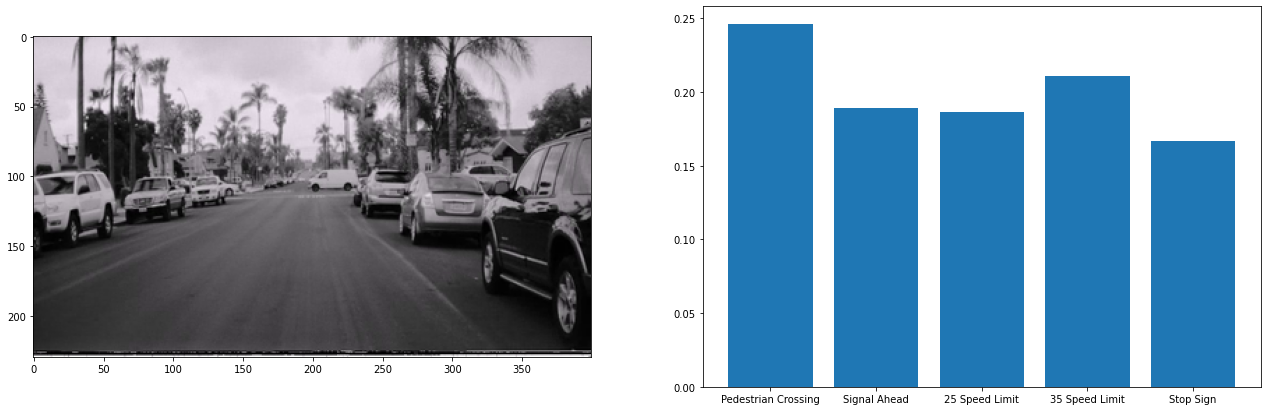

In [43]:
make_prediction_graph('/resized_images_400x230/test/stop/1008.png',
                      model_3)

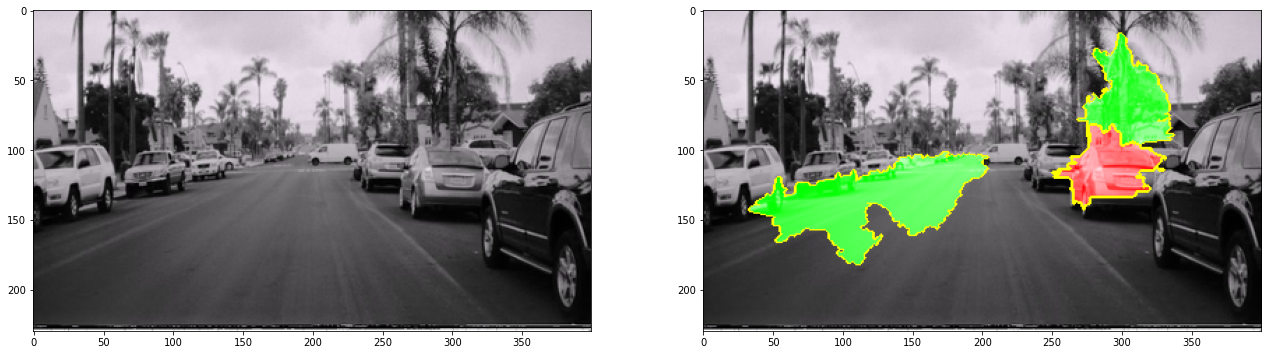

In [44]:
lime_explain('/resized_images_400x230/test/stop/1008.png',
             model_3)

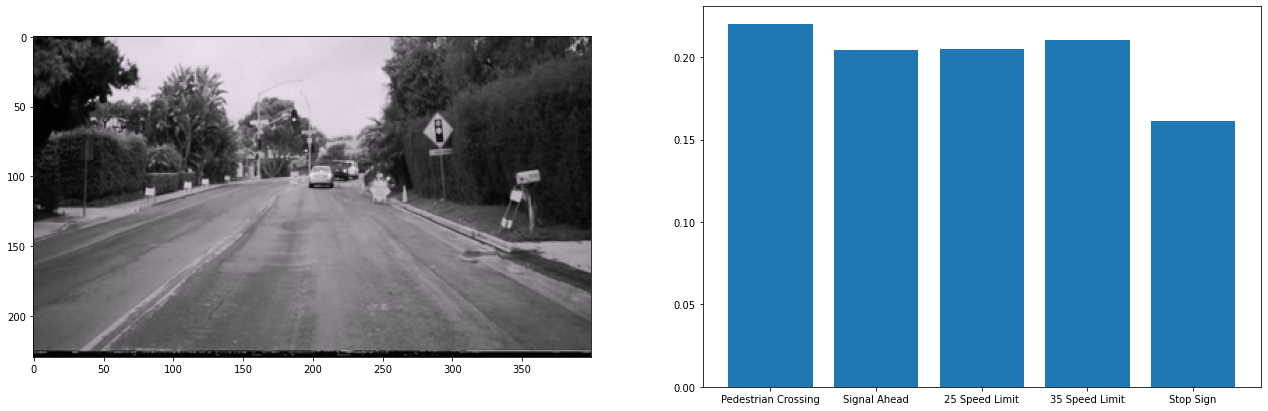

In [45]:
make_prediction_graph('/resized_images_400x230/test/signalAhead/1944.png',
                      model_3)

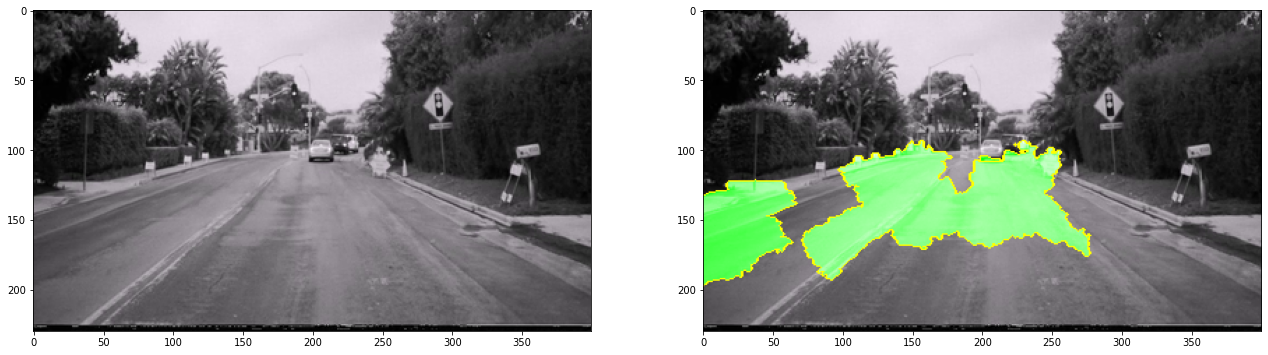

In [46]:
lime_explain('/resized_images_400x230/test/signalAhead/1944.png',
             model_3)

As with the previous model, the pretrained model is significantly less confident in its answers. There is still no improvement on identifying the correct superpixels, but the fact that the label predictions are less confident is an indication that there isn't enough diversity in the data to reliably distinguish between the different traffic signs.

While the pictures we've visualized so far are effectively grayscale, despite being stored as RGB, we also have true color images within the LISA dataset as well. Let's take a look at a couple of them.

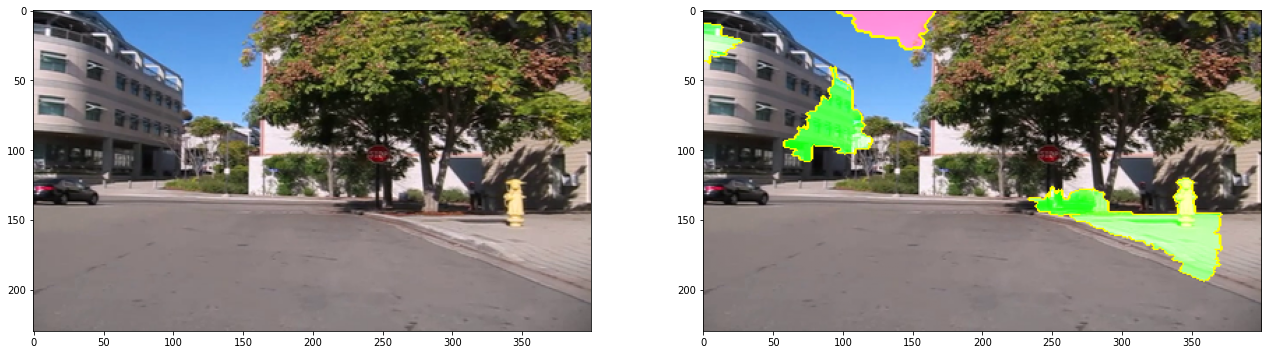

In [48]:
lime_explain('/resized_images_400x230/test/stop/3771.png',
             model_3)

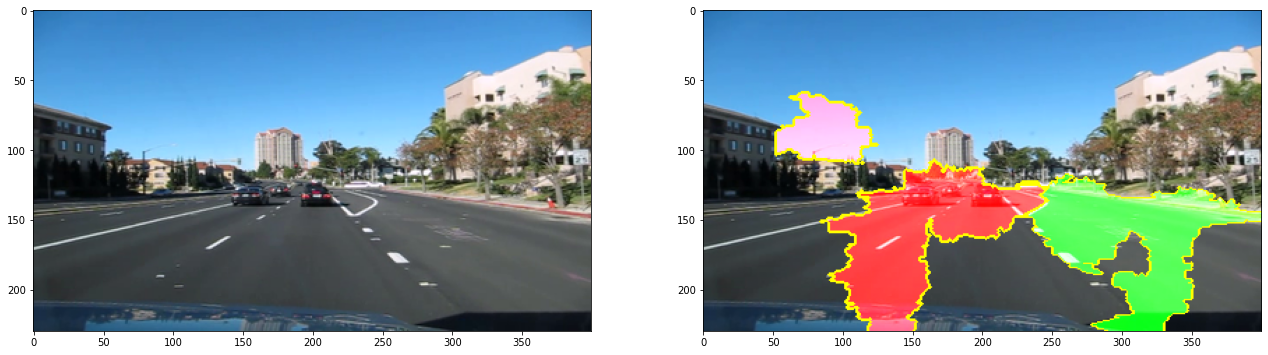

In [49]:
lime_explain('/resized_images_400x230/test/speedLimit25/3941.png',
             model_3)

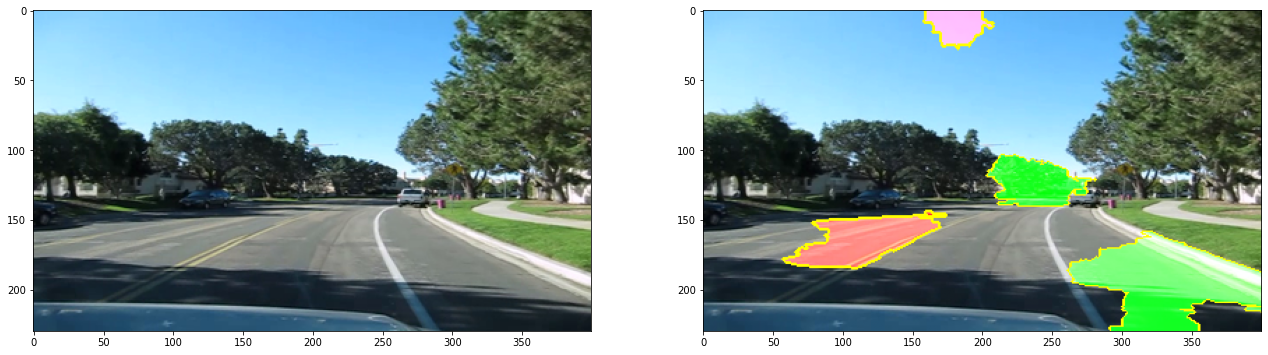

In [51]:
lime_explain('/resized_images_400x230/test/pedestrianCrossing/3907.png',
             model_3)

There doesn't seem to be any difference; the model fails to look at the sign itself in both types of pictures. 

# Applying Models to Different Resolutions

Up until now, we've used pictures only coming from the LISA dataset. What if we used a set of different pictures obtained from Google Street View instead? Would the model do better or worse?

In [54]:
test_generator = test_datagen.flow_from_directory('/prediction_images/prediction', 
                                                  target_size=(230, 400), 
                                                  batch_size=1, 
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 55 images belonging to 5 classes.


In [0]:
model_preds = model.predict(test_generator, steps=55)
model_2_preds = model_2.predict(test_generator, steps=55)
model_3_preds = model_3.predict(test_generator, steps=55)

In [0]:
# we'll need a slightly different function for prediction viewing

def lime_explain_preds(pic_num, model):
  
  explainer = lime_image.LimeImageExplainer()

  explanation = explainer.explain_instance(test_generator[pic_num][0][0], model.predict, top_labels=5, hide_color=0, num_samples=1000)

  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)#, min_weight=0.2)
  fig = plt.figure(figsize=(11,7))
  plt.imshow(mark_boundaries(temp, mask))

  print(sorted(list(zip(explanation.top_labels, tags)))[0])

(0, 'signalAhead')


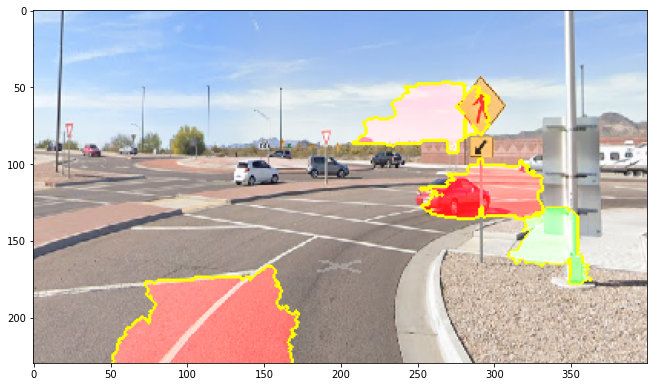

In [85]:
lime_explain_preds(3, model=model)

(0, 'pedestrianCrossing')


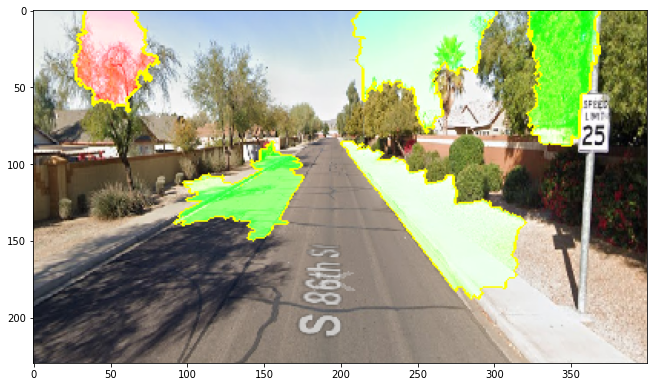

In [86]:
lime_explain_preds(27, model=model_2)

(0, 'signalAhead')


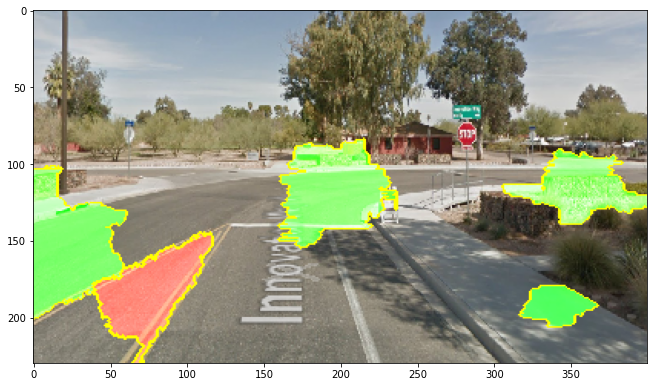

In [83]:
lime_explain_preds(54, model=model_3)

As expected, we see the same behavior from the models on a variety of testing images as well. Each model appears not to take into consideration that actual sign when predicting the associated label. 

# Summary & Conclusions

We saw a set of models, both scratch-written and pre-trained, that achieved varying yet significant levels of accuracy in determining traffic sign types. Using Lime, however, we were able to see that the sign itself rarely, if ever, contributed to the predictions made by any of the models. Instead, features like roads, trees, cars, and even patches of sky were ultimately deemed more significant in the prediction process. 

A major point of consideration is that the LISA dataset is a rather small one; it contains fewer than 8000 pictures with traffic signs in it. Further still, we were only using a fraction of it; 3,767 images were used for training, with 201 set aside for validation. The thing that all of the pictures within this dataset have in common is the traffic sign in question taking up a very small fraction of the picture's total area. 

Both of these two points mean that we effectively set out to create models that were capable of teaching themselves, *in just a few thousand examples*, how to ignore more than 90% of the total area of a picture. Anyone familiar with machine learning in general will understand how Herculean this task is. Either we must cut down on the total area of the pictures used for training and validation, or we must vastly increase the total number of training and validation examples. For autonomous vehicle companies, such as Uber and Waymo, the latter path is much more possible, and perhaps the more necessary one, to travel (pun somewhat intended).

